In [1]:
import pandas as pd
import librosa
import os
import numpy as np 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

In [2]:
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2
import tensorflow as tf

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Arquivo de metadados

In [3]:
#audio_path = 'spectogram/'
#spectograms = os.listdir(audio_path)

#metadata with most_freq chords indicator
df = pd.read_csv('metadata_final.csv', sep = ',')
df_chords = df


## PCP

In [4]:
X = np.load("X_total-PCP.npy")
y = np.load("y_total-PCP.npy")

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [7]:
X_train.shape

(1447, 12, 1216)

## Custom Model

In [20]:
import mlflow

mlflow.tensorflow.autolog(every_n_iter = 2)

2023/11/08 21:19:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [10]:
X_train.reshape(755,1216,12).shape

(755, 1216, 12)

In [8]:
# How data should be structured
num_rows = round(1216/4)
num_columns = 12*4 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [51]:
def create_model():

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model


model = create_model()

In [52]:
model.compile(
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()],  
    optimizer='adam')

# Display model architecture summary 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 302, 46, 32)       320       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 302, 46, 32)       0         
                                                                 
 batch_normalization_19 (Ba  (None, 302, 46, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 300, 44, 32)       9248      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 300, 44, 32)       0         
                                                                 
 batch_normalization_20 (Ba  (None, 300, 44, 32)       128       
 tchNormalization)                                    

In [53]:
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=4, 
                    epochs=10, 
                    validation_data=(X_test,y_test_encoded),
                    verbose=1)

2023/10/28 19:59:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fba0af536eaf4a6abcf404ece55dd584', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
189/189 [==============================] - 34s 170ms/step - loss: 2.2845 - categorical_accuracy: 0.1444 - val_loss: 3.0167 - val_categorical_accuracy: 0.1046
Epoch 2/10
189/189 [==============================] - 32s 171ms/step - loss: 2.2588 - categorical_accuracy: 0.1656 - val_loss: 3.4980 - val_categorical_accuracy: 0.1046
Epoch 3/10
189/189 [==============================] - 32s 171ms/step - loss: 2.2412 - categorical_accuracy: 0.1762 - val_loss: 2.2688 - val_categorical_accuracy: 0.1957
Epoch 4/10
189/189 [==============================] - 32s 171ms/step - loss: 2.2230 - categorical_accuracy: 0.1762 - val_loss: 3.4706 - val_categorical_accuracy: 0.1180
Epoch 5/10
189/189 [==============================] - 33s 173ms/step - loss: 2.1928 - categorical_accuracy: 0.1947 - val_loss: 2.3382 - val_categorical_accuracy: 0.1743
Epoch 6/10
189/189 [==============================] - 33s 173ms/step - loss: 2.1929 - categorical_accuracy: 0.2172 - val_loss: 3.6543 - val_categorical_acc

INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmppomra81a\model\data\model\assets
2023/10/28 20:05:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "e:\MDNE\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Feed Forward Network

In [9]:
X_train_ffn = X_train.reshape(1447,1216,12)
X_test_ffn =  X_test.reshape(713,1216,12)

In [12]:
X_test.shape

(373, 12, 1216)

In [10]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_train_encoded = le.fit_transform(y_train)

#mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [21]:


def sigmoid(hidden_layer):
    model_relu = tf.keras.models.Sequential([ 
        tf.keras.layers.Flatten(input_shape=(1216,12)), 
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dense(42,activation='softmax')
  ]) 

#Compiling using loss function, Optimizer and Metrics
    model_relu.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model_relu



#Feeding the model and Evalutating the Accuracy
def model_fitting(model_fit):
    model_fit.fit(X_train_ffn, y_train_encoded, epochs=150)
    test_loss, test_accuracy = model_fit.evaluate(X_test_ffn,  y_test_encoded, verbose=2)
    print('\nTest accuracy:', test_accuracy)
    return test_accuracy, test_loss

#Intializing the final array
err = np.zeros(4)
loss = np.zeros(4)

#ReLU with 128 hidden values
model = sigmoid(128)
err[0],loss[0] = model_fitting(model)

2023/11/08 21:19:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a934a61c60f74f38b8c27014885bda9e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/150
46/46 [==============================] - 2s 36ms/step - loss: 3.2037 - accuracy: 0.2702
Epoch 2/150
46/46 [==============================] - 2s 35ms/step - loss: 1.5788 - accuracy: 0.5750
Epoch 3/150
46/46 [==============================] - 2s 34ms/step - loss: 1.0289 - accuracy: 0.7049
Epoch 4/150
46/46 [==============================] - 2s 35ms/step - loss: 0.7938 - accuracy: 0.7657
Epoch 5/150
46/46 [==============================] - 2s 33ms/step - loss: 0.6798 - accuracy: 0.7885
Epoch 6/150
46/46 [==============================] - 2s 34ms/step - loss: 0.5428 - accuracy: 0.8293
Epoch 7/150
46/46 [==============================] - 2s 34ms/step - loss: 0.4349 - accuracy: 0.8645
Epoch 8/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3869 - accuracy: 0.8874
Epoch 9/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3507 - accuracy: 0.8977
Epoch 10/150
46/46 [==============================] - 2s 33ms/step - loss: 0.2970 - accuracy: 0.9129

INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmpjqbufxtp\model\data\model\assets
2023/11/08 21:23:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "e:\MDNE\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


23/23 - 0s - loss: 2.2525 - accuracy: 0.7391 - 193ms/epoch - 8ms/step

Test accuracy: 0.739130437374115


## Metrics

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

preds_score = model.predict(X_test)
pred_idx = tf.math.argmax(preds_score, axis = 1)
#y_test_idx = tf.math.argmax(y_test_encoded, axis = 1)
target_names = mapping.keys()

print('F1-Score: ', f1_score(y_test_encoded, pred_idx, average = 'macro'))
print('F1-Score: ', f1_score(y_test_encoded, pred_idx, average = 'macro'))

print(classification_report(y_test_encoded, pred_idx, target_names= target_names))


23/23 [==============================] - 0s 4ms/step
F1-Score:  0.6428898093241839
F1-Score:  0.6428898093241839
              precision    recall  f1-score   support

        A#:7       0.00      0.00      0.00         3
    A#:hdim7       0.33      0.67      0.44         3
      A#:maj       0.65      0.81      0.72        32
      A#:min       0.93      0.76      0.84        17
         A:7       0.67      1.00      0.80         4
     A:hdim7       1.00      0.33      0.50         3
       A:maj       0.73      0.87      0.79        31
       A:min       0.62      0.73      0.67        11
       B:maj       0.56      0.69      0.62        26
       B:min       0.56      0.36      0.43        14
        C#:7       0.12      0.11      0.12         9
    C#:hdim7       1.00      1.00      1.00         3
      C#:maj       0.88      0.82      0.85        45
      C#:min       0.80      0.80      0.80        15
         C:7       0.92      0.80      0.86        15
     C:hdim7       0.8

In [25]:
y_test_encoded.shape

(713,)

In [35]:
from sklearn.metrics import f1_score
import tensorflow as tf
#print('Acurácia: ', f1_score(y_test, preds))

<tf.Tensor: shape=(373,), dtype=int64, numpy=
array([4, 1, 2, 1, 0, 7, 1, 3, 6, 4, 6, 4, 6, 7, 5, 8, 5, 8, 3, 8, 5, 0,
       0, 7, 7, 1, 3, 3, 7, 2, 5, 7, 3, 2, 9, 5, 4, 4, 3, 4, 3, 9, 0, 6,
       5, 8, 9, 1, 3, 4, 7, 8, 8, 1, 5, 4, 7, 1, 7, 7, 4, 9, 9, 0, 9, 7,
       8, 9, 9, 3, 1, 1, 7, 9, 0, 7, 7, 1, 8, 2, 8, 9, 7, 5, 1, 0, 7, 5,
       1, 1, 5, 4, 2, 8, 0, 7, 9, 5, 1, 6, 9, 5, 8, 9, 4, 8, 2, 6, 9, 0,
       9, 2, 5, 4, 7, 7, 3, 6, 0, 9, 6, 5, 6, 3, 1, 5, 3, 1, 2, 4, 7, 5,
       9, 2, 8, 2, 4, 6, 2, 6, 9, 4, 3, 1, 4, 9, 1, 4, 8, 9, 5, 6, 6, 7,
       7, 1, 3, 7, 3, 8, 2, 7, 1, 6, 5, 9, 4, 2, 8, 6, 9, 2, 2, 6, 0, 5,
       2, 8, 0, 8, 8, 0, 5, 0, 7, 4, 7, 5, 1, 9, 2, 9, 7, 8, 0, 4, 7, 3,
       3, 7, 0, 9, 6, 2, 9, 3, 0, 9, 9, 6, 4, 1, 3, 2, 7, 4, 4, 9, 8, 6,
       1, 7, 1, 5, 0, 1, 8, 2, 2, 6, 7, 1, 7, 7, 6, 1, 2, 4, 1, 7, 3, 1,
       8, 4, 9, 4, 9, 7, 8, 5, 8, 4, 9, 2, 9, 2, 8, 7, 1, 4, 1, 4, 2, 1,
       0, 0, 1, 8, 2, 2, 6, 6, 4, 9, 7, 4, 7, 5, 3, 4, 5, 7, 9, 5, 5, 9,
     

## MobileNet

In [10]:
#ref -> https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [57]:
import mlflow

mlflow.tensorflow.autolog(every_n_iter = 2)

2023/10/28 20:06:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [24]:



def add_channels(array):

    arr = np.expand_dims(array, axis = -1)
    # pad the missing dims with zeros
    pad = ((0,0),)*3 + ((0,2),)
    padded = np.pad(arr, pad, 'constant', constant_values = 0)

    padded = padded.reshape(padded.shape[0], padded.shape[1]*4, round(padded.shape[2]/4), 3)
    

    return padded

X_train_mobile = add_channels(X_train)
X_test_mobile = add_channels(X_test)

IMG_SHAPE = (X_train_mobile.shape[1],X_train_mobile.shape[2] ,3)



base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE),
                                               include_top=False,
                                               weights='imagenet')


In [25]:

feature_batch = base_model(X_train_mobile)
print(feature_batch.shape)


(755, 2, 10, 1280)


In [42]:
base_model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [44]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 304, 3)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 24, 152, 32)          864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 24, 152, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 24, 152, 32)          0         ['bn_Conv1[

In [45]:
prediction_layer = tf.keras.layers.Dense(10, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [46]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [62]:
base_learning_rate = 0.4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [57]:
len(model.trainable_variables)


56

In [63]:
initial_epochs = 30

history = model.fit(X_train_mobile, y_train_encoded,
                    epochs=initial_epochs,
                    validation_data=(X_test_mobile, y_test_encoded))



Epoch 1/30
24/24 [==============================] - 17s 477ms/step - loss: 3.8117 - categorical_accuracy: 0.1007 - val_loss: 3.3813 - val_categorical_accuracy: 0.0992
Epoch 2/30
24/24 [==============================] - 11s 447ms/step - loss: 2.6931 - categorical_accuracy: 0.1232 - val_loss: 2.4942 - val_categorical_accuracy: 0.1046
Epoch 3/30
24/24 [==============================] - 11s 456ms/step - loss: 2.6084 - categorical_accuracy: 0.1086 - val_loss: 2.4462 - val_categorical_accuracy: 0.1340
Epoch 4/30
24/24 [==============================] - 11s 446ms/step - loss: 2.7467 - categorical_accuracy: 0.1007 - val_loss: 3.0385 - val_categorical_accuracy: 0.0992
Epoch 5/30
24/24 [==============================] - 11s 445ms/step - loss: 2.9668 - categorical_accuracy: 0.0980 - val_loss: 2.7108 - val_categorical_accuracy: 0.1046
Epoch 6/30
24/24 [==============================] - 11s 447ms/step - loss: 2.7223 - categorical_accuracy: 0.1113 - val_loss: 2.6593 - val_categorical_accuracy: 0.134

In [87]:
y_train_encoded.shape

(755, 10)

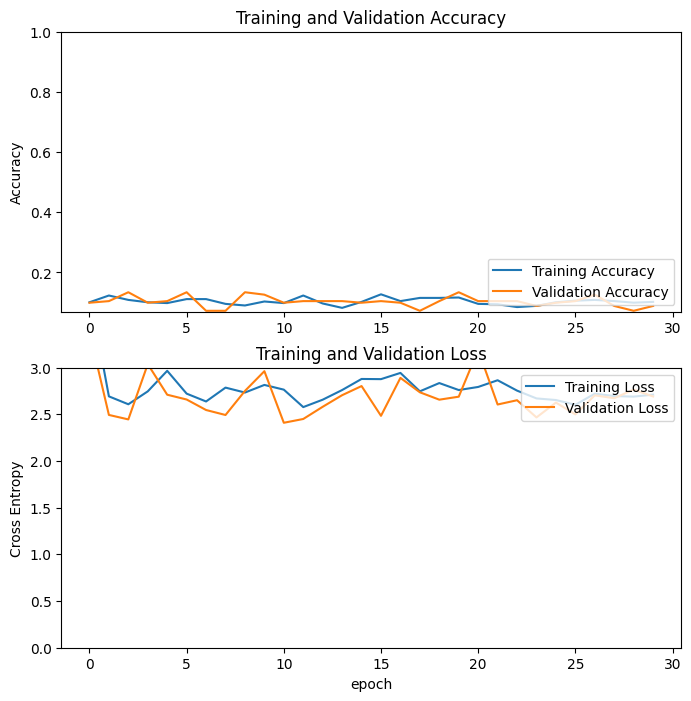

In [64]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## EfficientNet

In [37]:

IMG_SHAPE = (X_train.shape[1], X_train.shape[2],3)


def add_channels(array):

    arr = np.expand_dims(array, axis = -1)
    # pad the missing dims with zeros
    pad = ((0,0),)* + ((0,2),)
    padded = np.pad(arr, pad, 'constant', constant_values = 0)

    return padded

X_train_mobile = add_channels(X_train)
X_test_mobile = add_channels(X_test)





base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation='softmax')

ValueError: Input size must be at least 32x32; Received: input_shape=(1216, 12, 3)

In [47]:
feature_batch = base_model(X_train_mobile)
#print(feature_batch.shape)

base_model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [48]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 40, 608, 3)]         0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 40, 608, 3)           0         ['input_7[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 40, 608, 3)           7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 40, 608, 3)           0         ['normalization_1

In [49]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  238


In [50]:
prediction_layer = tf.keras.layers.Dense(10, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)


inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [52]:
initial_epochs = 10

history = model.fit(X_train_mobile, y_train_encoded,
                    epochs=initial_epochs,
                    validation_data=(X_test_mobile, y_test_encoded))

2023/10/23 20:30:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab7e15a25c4c44b69afe1de125beea2f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
24/24 [==============================] - 67s 2s/step - loss: 2.4159 - categorical_accuracy: 0.0967 - val_loss: 2.3217 - val_categorical_accuracy: 0.0724
Epoch 2/10
24/24 [==============================] - 44s 2s/step - loss: 2.3498 - categorical_accuracy: 0.1113 - val_loss: 2.3249 - val_categorical_accuracy: 0.1340
Epoch 3/10
24/24 [==============================] - 44s 2s/step - loss: 2.3431 - categorical_accuracy: 0.0993 - val_loss: 2.3161 - val_categorical_accuracy: 0.0724
Epoch 4/10
24/24 [==============================] - 44s 2s/step - loss: 2.3424 - categorical_accuracy: 0.1073 - val_loss: 2.5713 - val_categorical_accuracy: 0.0724
Epoch 5/10
24/24 [==============================] - 45s 2s/step - loss: 2.3332 - categorical_accuracy: 0.1020 - val_loss: 2.3034 - val_categorical_accuracy: 0.1340
Epoch 6/10
24/24 [==============================] - 44s 2s/step - loss: 2.3350 - categorical_accuracy: 0.1311 - val_loss: 2.3039 - val_categorical_accuracy: 0.1340
Epoch 7/10
24/24

1/1 [==============================] - 1s 1s/step
INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmpo_24iqls\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmpo_24iqls\model\data\model\assets


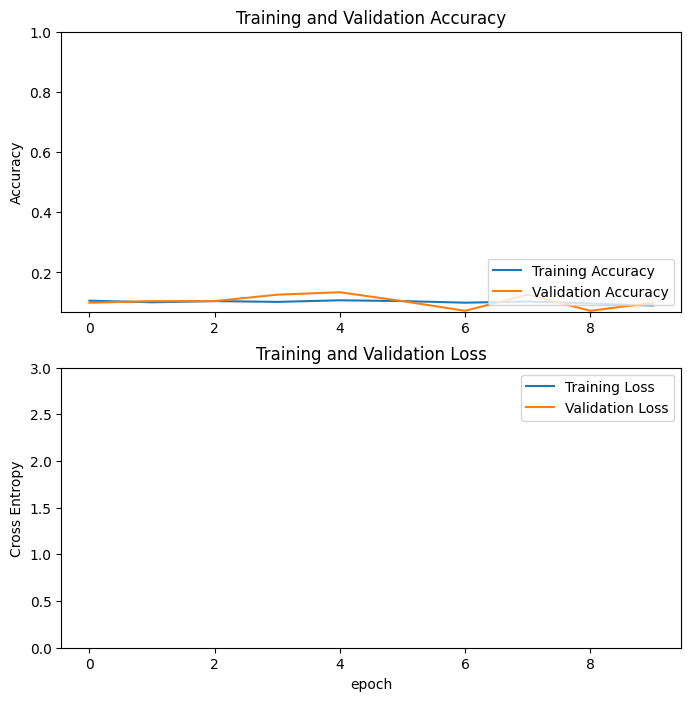

In [44]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()